# Using the ml4qc package for a specific example analysis ("CAPI1")

This workbook demonstrates an example analysis for a particular CAPI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CAPI1".

This is a basic proof-of-concept project designed to explore the potential for ML-based tools to identify outliers and submissions that are likely to be rejected by a human reviewer. The project collected some but not all possible metadata, and every submission was reviewed.

Too few submissions were rejected to predict rejection, so instead we predict "not approved as GOOD quality" with a base rate of 70%. None of the models do a very good job predicting this outcome with much better precision than random selection, and it's not clear whether a larger sample size would help. Ideally, we'd need to learn more about what drove the review decisions, and how systematic vs. idiosyncratic the decision-making was.

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **mean_light_level** - Mean light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **sd_light_level** - Standard deviation of light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **mean_movement** - Mean device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **sd_movement** - Standard deviation of device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **mean_movement** - Mean sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **sd_movement** - Standard deviation of sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_quiet** - Percent of form-editing time when it was quiet ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_still** - Percent of form-editing time when the device was still ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **duration** - Total number of seconds spent editing form
* **TA** - Name of text audit `.csv` file
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/capi1/capi1.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate      824
starttime           824
endtime             824
mean_light_level    198
sd_light_level      198
mean_movement       297
sd_movement         297
mean_sound_level    824
sd_sound_level      824
pct_quiet           824
pct_still           824
duration            824
TA                  824
review_status       824
review_quality      824
dtype: int64

Submission DataFrame review status and quality:
APPROVED    819
REJECTED      5
Name: review_status, dtype: Int64
OKAY    572
GOOD    247
POOR      5
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         76147
duration_s    76147
visited_s     76147
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                                        824
starttime                                                                                             824
endtime                                            

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using "submissions that are not APPROVED as GOOD quality" (i.e., rejected or another quality) as the target.

Here, we use PCA to reduce our feature dimensions, targeting 99% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [3]:
from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.99

# random state for reproducible results (or None)
random_state = 411

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["SubmissionDate", "starttime", "endtime", "duration", "TA", "mean_light_level", "sd_light_level", "mean_movement", "sd_movement"], axis=1).copy(deep=True)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
target_description = "Not APPROVED+GOOD"
classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=random_state, verbose=True, reweight_classes=True, n_jobs=-2)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Target description: Not APPROVED+GOOD
1    577
0    247
Name: target, dtype: int64

numeric features: 1183
numeric_binary features: 442
numeric_unit_interval features: 730
numeric_other features: 11
datetime features: 0
other features: 2
  Starting training set shape: (618, 1185)
Starting prediction set shape: (206, 1185)
     Final training set shape: (618, 238)
   Final prediction set shape: (206, 238)


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [4]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser("~/ml4qc-data/collab1/capi1/outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 26 (3.1553398058252426%)
CPU times: user 279 ms, sys: 58.7 ms, total: 338 ms
Wall time: 343 ms


target,0,1
is_outlier,,
0,0.967611,0.968804
1,0.032389,0.031196


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Logistic regression
     Scoring: average_precision

Running random CV search for best hyperparameters...

   Scoring: average_precision
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best average_precision: 0.7597326974651186
Parameters: {'C': 0.02744603755652782, 'class_weight': 'balanced', 'penalty': 'l2'}

Running prediction model...

  Training set: (618, 238) (433 positive)
Prediction set: (206, 238)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  80.42%
         Train precision:  93.09%
     Train avg precision:  95.88%
               Train F-1:  0.85
     Prediction accuracy:  54.37%
    Prediction precision:  73.15%
Prediction avg precision:  74.92%
          Prediction F-1:  0.63
      Test ROC_AUC Score:  0.54

Cross validation results: 

fit_time: 0.008626302083333334 (SD: 0.0005816663609505301)
score_time: 0.0015850067138671875 (SD: 0.0001158247501763

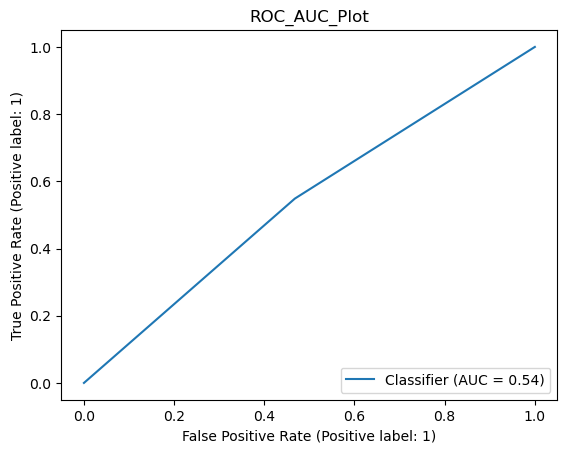

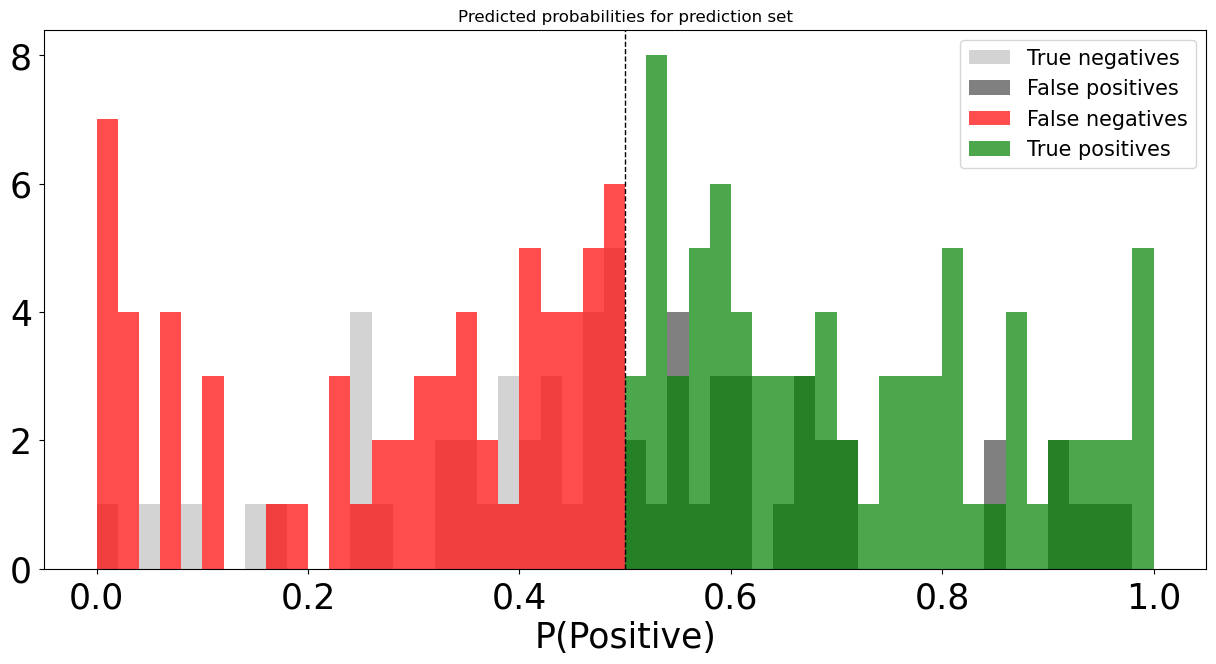

Test P(1) =  69.90%
Test P(1 | predicted 1) =  73.15%
Test P(1 | predicted 0) =  66.33%

              precision    recall  f1-score   support

           0       0.34      0.53      0.41        62
           1       0.73      0.55      0.63       144

    accuracy                           0.54       206
   macro avg       0.53      0.54      0.52       206
weighted avg       0.61      0.54      0.56       206



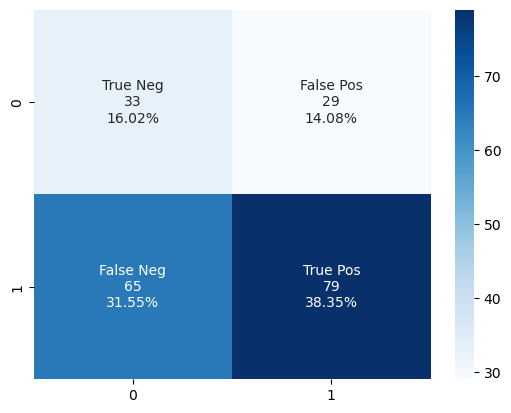

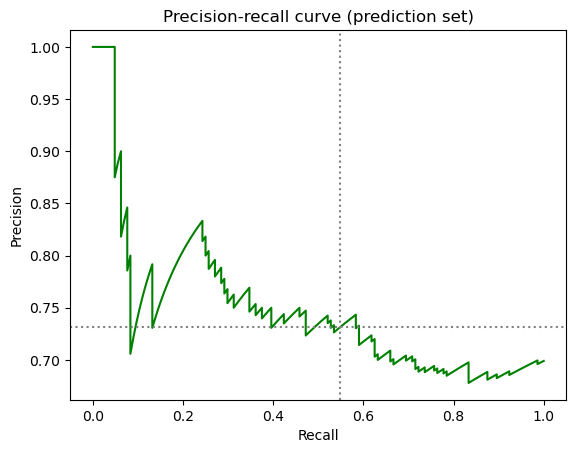

Predictions made: 206
CPU times: user 826 ms, sys: 180 ms, total: 1.01 s
Wall time: 9.5 s


In [5]:
%%time

model_description = "Logistic regression"
model_scoring = 'average_precision'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import sklearn as skl
from sklearn.linear_model import LogisticRegression

# first use cross validation to find the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': ['balanced', None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_lr.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Decision tree
     Scoring: average_precision

Running random CV search for best hyperparameters...

   Scoring: average_precision
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best average_precision: 0.7200360053782237
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': 'balanced'}

Running prediction model...

  Training set: (618, 238) (433 positive)
Prediction set: (206, 238)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  65.70%
         Train precision:  87.21%
     Train avg precision:  86.95%
               Train F-1:  0.71
     Prediction accuracy:  44.17%
    Prediction precision:  65.26%
Prediction avg precision:  68.45%
          Prediction F-1:  0.52
      Test ROC_AUC Score:  0.45

Cross validation results: 

fit_time: 0.003379201889038086 (SD: 0.0002537905588716024)
score_time: 0.00159

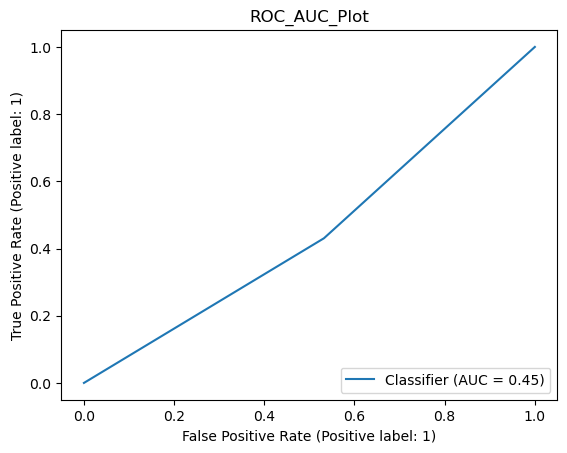

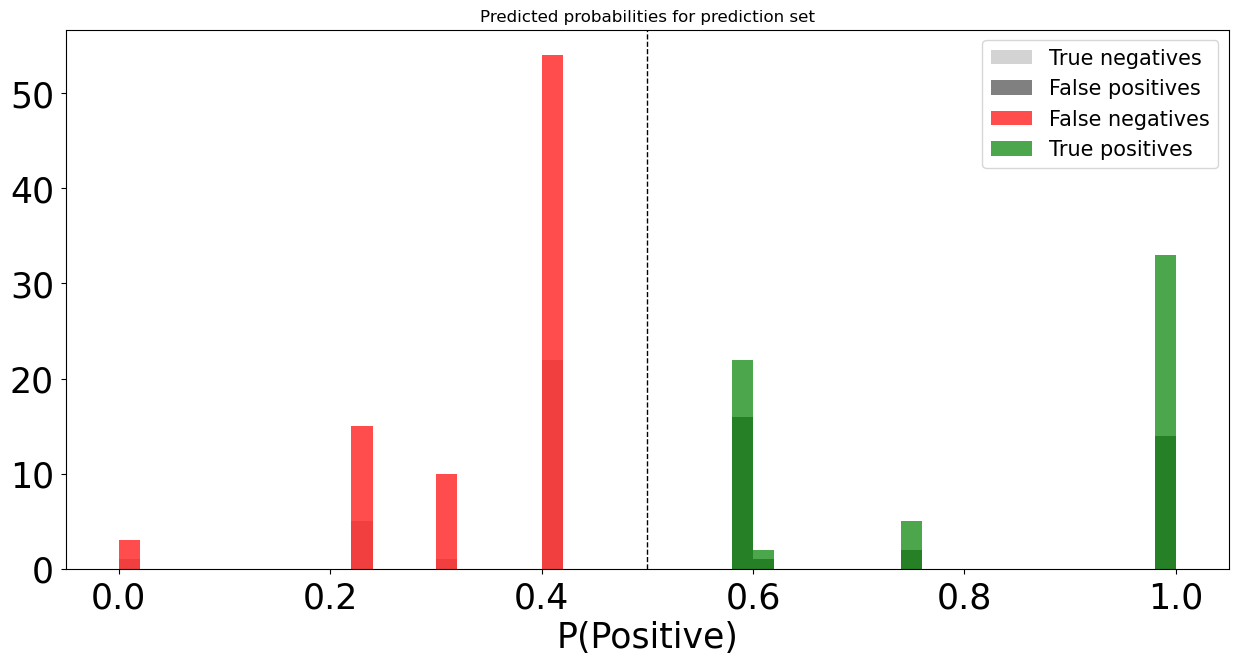

Test P(1) =  69.90%
Test P(1 | predicted 1) =  65.26%
Test P(1 | predicted 0) =  73.87%

              precision    recall  f1-score   support

           0       0.26      0.47      0.34        62
           1       0.65      0.43      0.52       144

    accuracy                           0.44       206
   macro avg       0.46      0.45      0.43       206
weighted avg       0.53      0.44      0.46       206



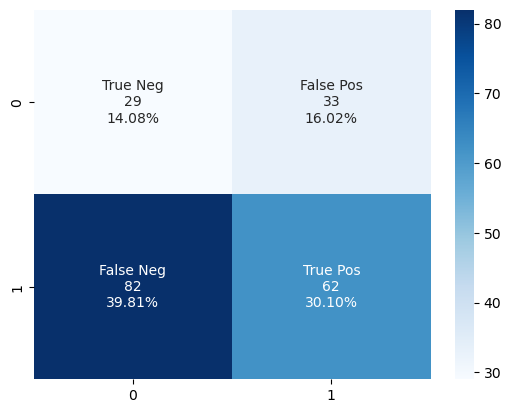

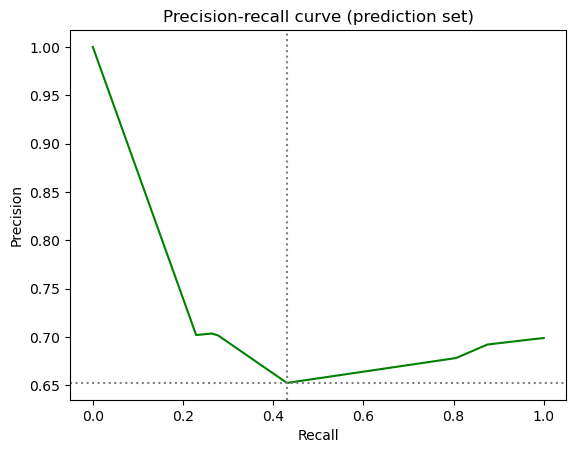

Predictions made: 206
CPU times: user 754 ms, sys: 69.9 ms, total: 824 ms
Wall time: 4.24 s


In [6]:
%%time

model_description = "Decision tree"
model_scoring = 'average_precision'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None, 'balanced']}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_dt.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Random forest
     Scoring: average_precision

Running random CV search for best hyperparameters...

   Scoring: average_precision
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best average_precision: 0.7658670952951477
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced', 'bootstrap': True}

Running prediction model...

  Training set: (618, 238) (433 positive)
Prediction set: (206, 238)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  100.00%
         Train precision:  100.00%
     Train avg precision:  100.00%
               Train F-1:  1.0
     Prediction accuracy:  70.87%
    Prediction precision:  70.59%
Prediction avg precision:  75.08%
          Prediction F-1:  0.83
      Test ROC_AUC Score:  0.52

Cross validation results: 

fit_time: 1.4316729068756104 (SD: 0.1224814592855909)
sc

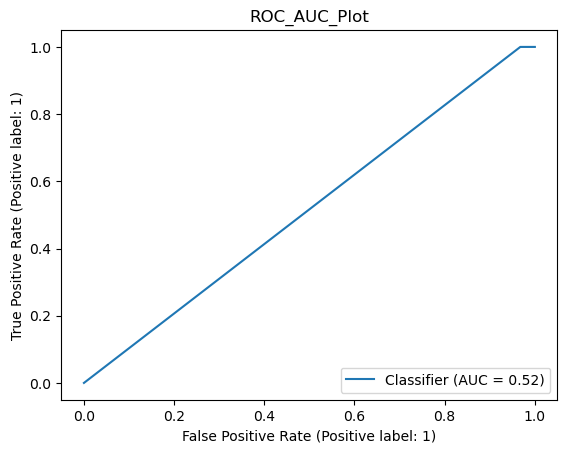

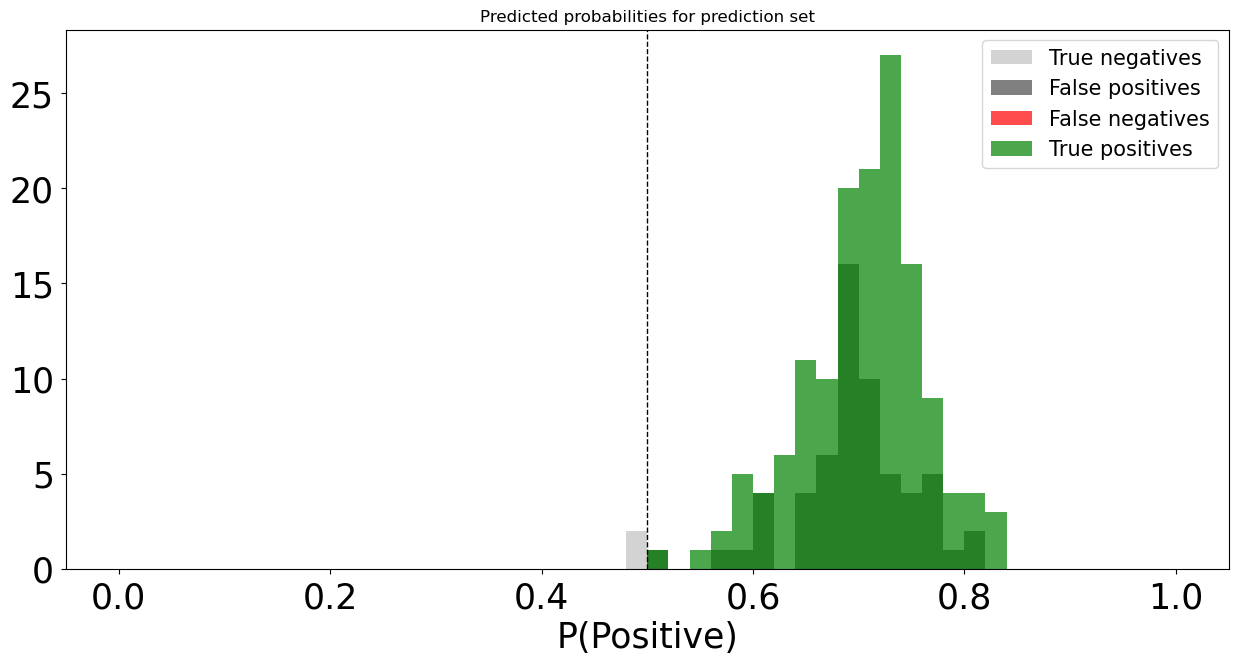

Test P(1) =  69.90%
Test P(1 | predicted 1) =  70.59%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        62
           1       0.71      1.00      0.83       144

    accuracy                           0.71       206
   macro avg       0.85      0.52      0.45       206
weighted avg       0.79      0.71      0.60       206



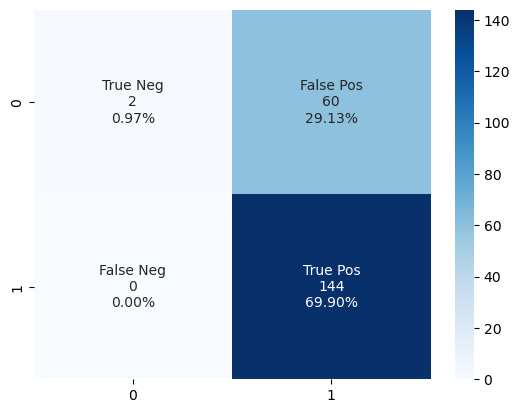

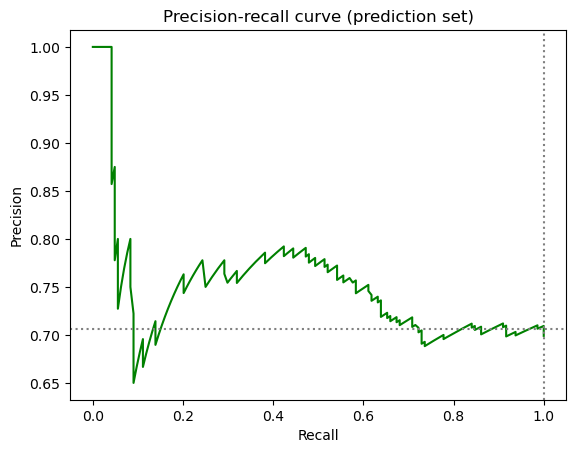

Predictions made: 206
CPU times: user 3.71 s, sys: 345 ms, total: 4.05 s
Wall time: 1min 21s


In [7]:
%%time

model_description = "Random forest"
model_scoring = 'average_precision'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None, 'balanced'], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_rf.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: XGBoost
     Scoring: average_precision

Running random CV search for best hyperparameters...

   Scoring: average_precision
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best average_precision: 0.7592595390677742
Parameters: {'subsample': 0.75, 'scale_pos_weight': 0.42725173210161665, 'min_child_weight': 2, 'max_depth': 7}

Running prediction model...

  Training set: (618, 238) (433 positive)
Prediction set: (206, 238)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  100.00%
         Train precision:  100.00%
     Train avg precision:  100.00%
               Train F-1:  1.0
     Prediction accuracy:  62.14%
    Prediction precision:  70.37%
Prediction avg precision:  72.09%
          Prediction F-1:  0.75
      Test ROC_AUC Score:  0.51

Cross validation results: 

fit_time: 1.1799325784047445 (SD: 0.0712457872692657)
score_time: 0.0038874149322509766 (SD: 0.000

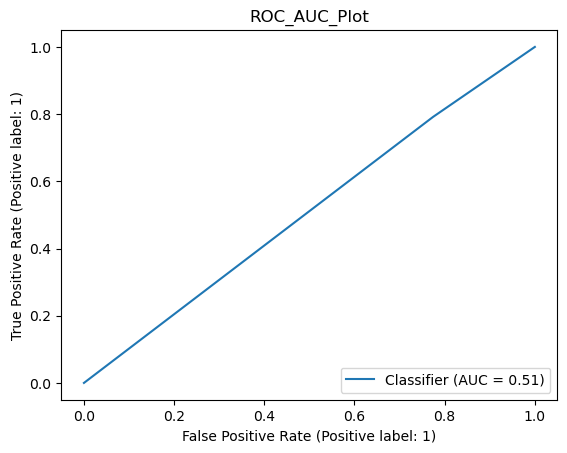

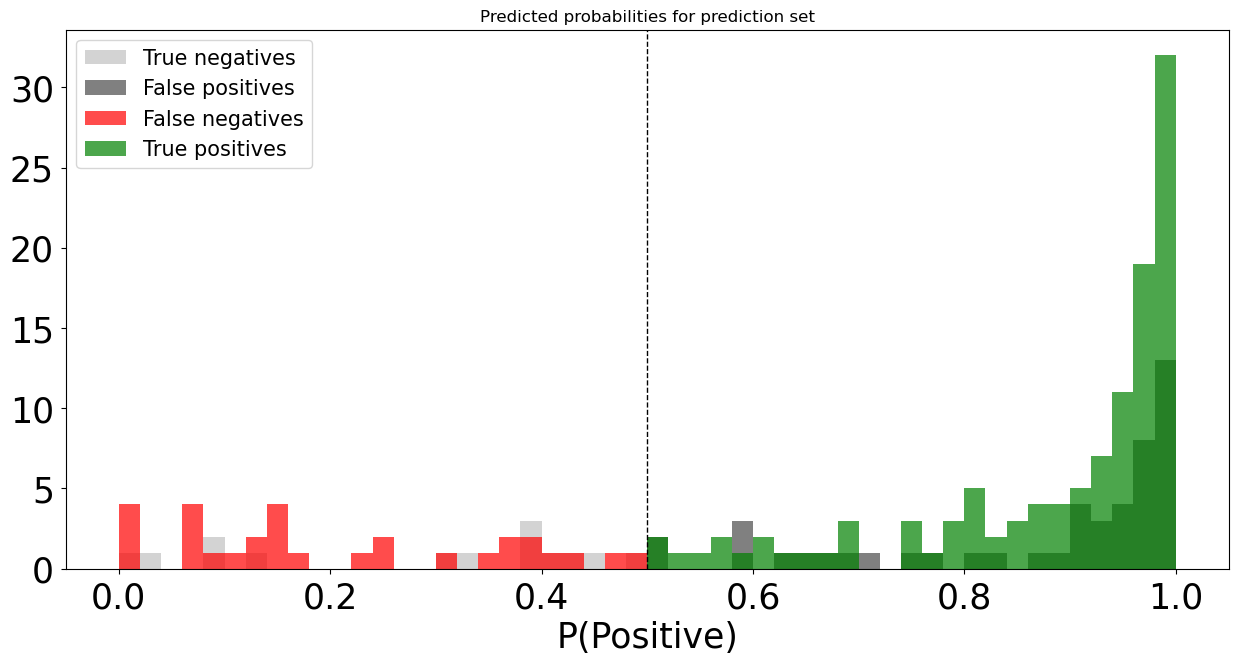

Test P(1) =  69.90%
Test P(1 | predicted 1) =  70.37%
Test P(1 | predicted 0) =  68.18%

              precision    recall  f1-score   support

           0       0.32      0.23      0.26        62
           1       0.70      0.79      0.75       144

    accuracy                           0.62       206
   macro avg       0.51      0.51      0.50       206
weighted avg       0.59      0.62      0.60       206



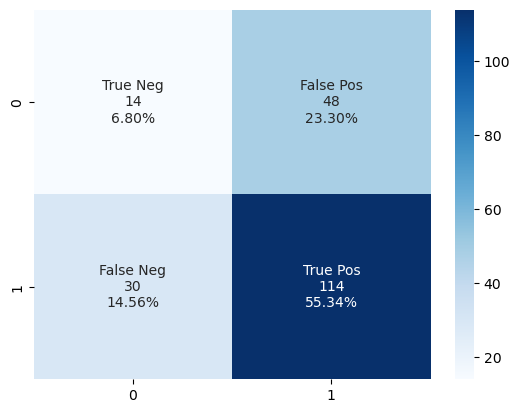

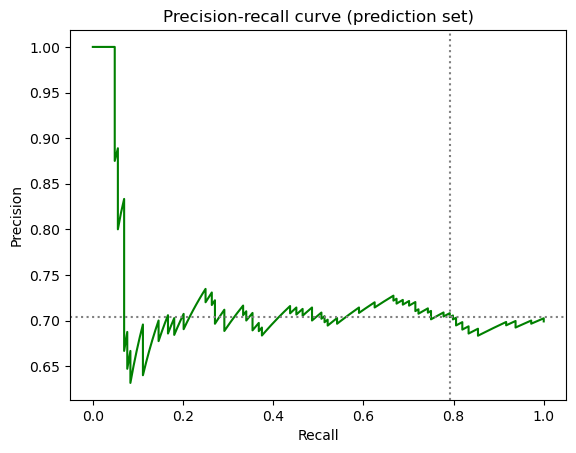

Predictions made: 206
CPU times: user 4.68 s, sys: 1.01 s, total: 5.69 s
Wall time: 59 s


In [8]:
%%time

model_description = "XGBoost"
model_scoring = 'average_precision'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1, surveyml.neg_train/surveyml.pos_train]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(classifier_xb.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Neural network
     Scoring: average_precision

Running random CV search for best hyperparameters...

   Scoring: average_precision
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


2022-12-19 17:11:19.189162: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:19.190847: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:19.191005: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:19.958104: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:20.200857: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:20.590203: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:20.777573: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:22.282927: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 17:11:22.389770: W tensorflow


Best average_precision: 0.7908319874725868
Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 80, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__features': 238, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': 119.0, 'model__l2_factor': 0.001743888323319341, 'model__l2_regularization': False, 'model__output_bias': None}

Running prediction model...

  Training set: (618, 238) (433 positive)
Prediction set: (206, 238)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  99.84%
         Train precision:  100.00%
     Train avg precision:  100.00%
               Train F-1:  1.0
     Prediction accuracy:  63.11%
    Prediction precision:  73.29%
Prediction avg precision:  75.77%
          Prediction F-1:  0.74
      Test ROC_AUC Score:  0.56

Cross validation results: 

fit_time: 2.4803473631540935 (SD: 0.4093637033402142)
score_time: 0.0803968111673991 (SD: 0.009519230583706706)
test_accu

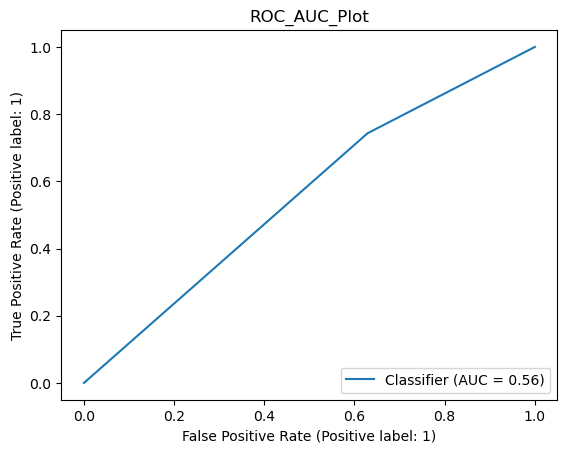

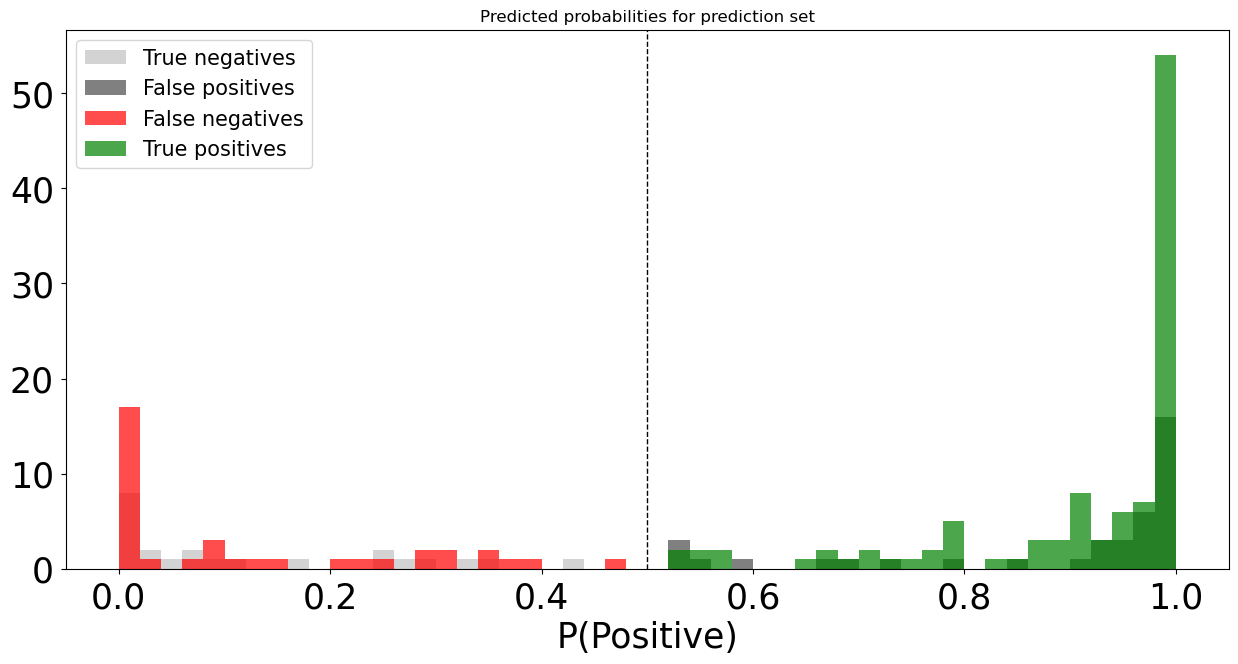

Test P(1) =  69.90%
Test P(1 | predicted 1) =  73.29%
Test P(1 | predicted 0) =  61.67%

              precision    recall  f1-score   support

           0       0.38      0.37      0.38        62
           1       0.73      0.74      0.74       144

    accuracy                           0.63       206
   macro avg       0.56      0.56      0.56       206
weighted avg       0.63      0.63      0.63       206



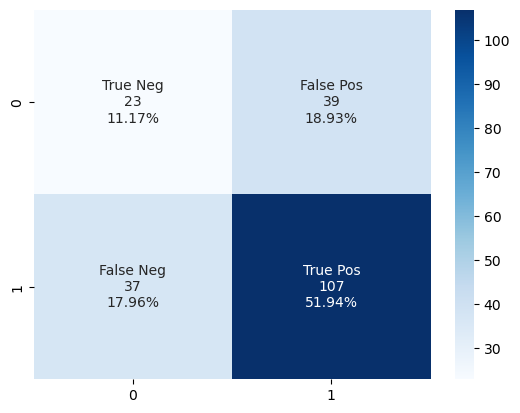

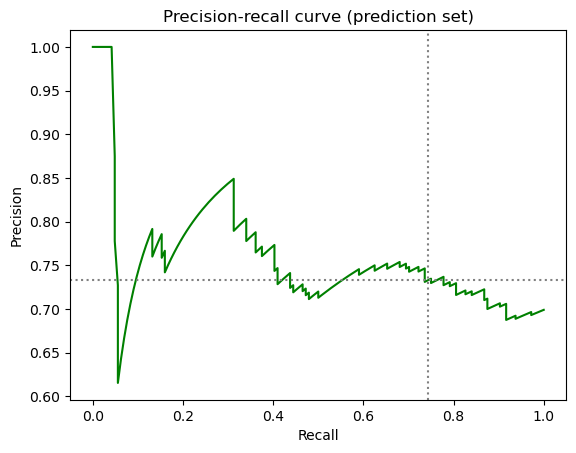

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 238)               0         
                                                                 
 dense_3 (Dense)             (None, 119)               28441     
                                                                 
 dropout_4 (Dropout)         (None, 119)               0         
                                                                 
 dense_4 (Dense)             (None, 59)                7080      
                                                                 
 dropout_5 (Dropout)         (None, 59)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 60        
                                                                 
Total params: 35,581
Trainable params: 35,581
Non-trai

In [9]:
%%time

model_description = "Neural network"
model_scoring = 'average_precision'  # 'average_precision' to optimize for precision, 'f1' to optimize for both precision and recall
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import numpy as np
from scikeras.wrappers import KerasClassifier

# first use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
#   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None, surveyml.class_weights], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print(classifier_nn.model_.summary())
print()
print(f"Predictions made: {len(predictions)}")